In [2]:
using Compose, CSV, Colors

In [3]:
function read_abundance_matrix(dir::String,t::Int64)
    return Array{Int64,2}(readdlm(dir * "otutable_whole_t" * lpad(t*10000,10,0) * ".csv",'\t',skipstart=1)[:,2:end])
end

function recover_status(track_info::Array{Int64,2},previous_status::Array{Int64,2},t0::Int64,t::Int64)
    
    status_matrix = copy(previous_status)
    for i = t0+1:t
        status_matrix[findfirst(status_matrix[:,1],track_info[i,1]),2] = status_matrix[findfirst(status_matrix[:,1],track_info[i,2]),2]
    end
    
    return status_matrix
end

recover_status (generic function with 1 method)

In [66]:
dir= "test_output/"
tStep = 200 # host time step to plot 

track_info = readdlm(dir * "death_reproduction_history",Int64)
host_time = size(track_info)[1]

Times = 0:tStep:host_time-1
hosts_matrices = [read_abundance_matrix(dir,t) for t in Times];

n_hosts = size(hosts_matrices[1])[2]
n_rows = size(Times)[1]

;

In [67]:
# function to rearrange the descendant's order to look at temporal dynamics 
function rearrange_descendants(track_info::Array{Int64,2}, previous_order::Array{Int64,1},actual_status::Array{Int64,2}, t0::Int64, t::Int64)
    n_hosts = length(previous_order)
    # we generate a dictionary to count the number of descendants when a lineage is mantained
    lineages = unique(actual_status[:,2])

    # we obtain the lineages sorted by the previous order
    
    sorted_ancesters = lineages[filter(x->x>0,[findfirst(lineages,previous_id) for previous_id in previous_order])]

    # reverse the death-birth track info and recover the last deaths
    rev_death, rev_birth = (reverse(track_info[t0+1:t,1]),reverse(track_info[t0+1:t,2]))
    
    dead_ids = unique(rev_death)
    not_dead_ids = deleteat!(collect(1:n_hosts),sort!(dead_ids))
    changes_matrix = Array{Int64,2}(length(dead_ids),3)
        
    # we obtain the moment each microbe_id died, its id, and the id of the microbe that replaced it
    for i in eachindex(dead_ids)
        time_index = findfirst(rev_death,dead_ids[i])
        changes_matrix[i,:] = [time_index,dead_ids[i],
            actual_status[findfirst(actual_status[:,1],dead_ids[i]),2]]
    end
    
    #we sort the matrix by the time each microbe_id died (from last to first)
    changes_matrix = sortrows(changes_matrix,by=x->x[1])
    new_arrangement = Array{Int64,1}(n_hosts)
    #print(changes_matrix)
    # we assign the positions acording to 1)the order of the microbes that replaced the dead and 2) the time at which
    # thet were replaced (first to last)
    count=1
    for ancester in sorted_ancesters
        time_indexes = reverse(findin(changes_matrix[:,3],ancester))
        
        for time_index in time_indexes
            new_arrangement[count]= changes_matrix[time_index,2]
            #println("ancester: ",ancester,"\tcount: ",count,"\tmicrobe_id: ",changes_matrix[time_index,2])
            count +=1
        end
          
        if in(ancester,not_dead_ids)
            new_arrangement[count]= ancester
            #println("ancester: ",ancester,"\tcount: ",count,"\tmicrobe_id: ",ancester)
            count +=1
        end  
    end
    
    # checking for inconsistensies
    #if length(unique(new_arrangement)) < n_hosts
    #    println("error")
    #else
    #    println("okay")
    #end
    
    # we return the new arrangement (microbe_ids sorted by the new position)

    #println(new_arrangement)
    return(new_arrangement)
end

rearrange_descendants (generic function with 1 method)

In [73]:
#plot properties
top_space = 0.12
right_space = 0.04

# circles properties
radius= (1-top_space) * tStep / host_time >= (1 - right_space) / n_hosts ? (1 - right_space) /(2 * n_hosts) : (1 - top_space)/(2 * n_rows)

center_xcoords = repmat([(1-right_space) * (i-1) / (n_hosts) + radius  for i = 1:n_hosts],n_rows)
center_ycoords = [(1-top_space) * (i-1) / (n_rows-1)  + top_space -  2 * radius for i = 1:n_rows for j=1:n_hosts]

# lines
lines_width = center_ycoords[n_hosts+1] - center_ycoords[1] > 3 * radius? 0.1mm : 0

n_lines = n_hosts*(n_rows-1)
lines_p1_ycoords = center_ycoords[1:n_lines]+radius * 1.5
lines_p2_ycoords = center_ycoords[n_hosts+1:end]-radius * 1.5



positions = Array{Int64,1}(n_hosts * n_rows)

positions[1:n_hosts]= collect(1:n_hosts)

hosts_status = Array{Int64,2}(n_hosts,2)
hosts_status[:] =repmat(collect(1:n_hosts),2)
all_status = Array{Int64,2}(n_hosts*n_rows,2)
all_status[1:50,:] =hosts_status

tmp_status = Array{Int64,2}(n_hosts,2) #matrix to rearrange the id and ancester values

for row=1:n_rows-1
    hosts_status = recover_status(track_info,hosts_status,Times[row],Times[row+1])
    positions[row*n_hosts+1:(row+1)*n_hosts] = rearrange_descendants(track_info, positions[(row-1)*n_hosts+1:row*n_hosts],hosts_status,Times[row],Times[row+1])

    all_status[row*n_hosts+1:(row+1)*n_hosts,:] = copy(hosts_status[:])
    
    for i=1:n_hosts
        hosts_status[i,2]=hosts_status[i,1]
    end
    
end


lines_p2_xcoords = center_xcoords

#colors
symbionts_vector = Array{Int64,1}(n_hosts * n_rows)

for i=1:n_rows
    symbionts_vector[(i-1)*n_hosts+1:i*n_hosts]= hosts_matrices[i][1,:]
end

max_sym = maximum(symbionts_vector)

cmap = colormap("Greens",max_sym+1)

# we use the ancestry to place the upper point of the line
lines_p1_xcoords = Array{Float64,1}(n_hosts * (n_rows-1))
color_vector[1:n_hosts] = cmap[1:n_hosts]
color_vector[1:n_hosts] = cmap[symbionts_vector[1:n_hosts]+1]

for row=1:n_rows-1
    lines_p1_xcoords[(row-1)*n_hosts+1:row*n_hosts] = center_xcoords[all_status[row*n_hosts+1:(row+1)*n_hosts,2]]
end


points_array = [[(lines_p1_xcoords[i],lines_p1_ycoords[i]),(lines_p2_xcoords[i],lines_p2_ycoords[i])] for i=1:n_lines]


# Annotations

# title
annot_title = [0.02,0.065,"Hosts ancestry dynamics"]

# time
annot_times_text = [string(t) for t in Times]
annot_times_x = 1- ( 7 * right_space / 8)
annot_times_y = unique(center_ycoords)+radius/2

annot_time_indicator = (1 - right_space, top_space - 0.05 ,"Time") 

annot_times = [push!(fill(annot_times_x,n_rows),annot_time_indicator[1]),
    push!(annot_times_y,annot_time_indicator[2]), 
    push!(annot_times_text,annot_time_indicator[3])]

# colorbar

colbar_len = 0.1
colbar_wid = 0.03
colbar_x_0 = (0.5 + annot_time_indicator[1])/2
colbar_y_0 = top_space - 0.05 - colbar_wid

x_s = colbar_x_0 + [colbar_len*i/(max_sym+1) for i = 0:max_sym] 
indiv_widths = colbar_len + colbar_x_0 - x_s

# colorbar text
colbar_title_x, colbar_title_y, colbar_title = (colbar_x_0 - 3 * radius,colbar_y_0 - radius,"Symbionts number")
colbar_low_x, colbar_low_y, colbar_low = (colbar_x_0 - 2 * radius, colbar_y_0 + 0.8 * colbar_wid ,"0")
colbar_high_x, colbar_high_y, colbar_high = (colbar_x_0 + radius / 2 + colbar_len,colbar_y_0 + 0.8 * colbar_wid ,string(max_sym))

annot_colbar = [[colbar_title_x,colbar_low_x,colbar_high_x],
    [colbar_title_y,colbar_low_y,colbar_high_y],
    [colbar_title,colbar_low,colbar_high]]

# simulation_data

;

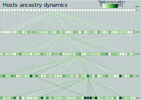

In [74]:
compose(context(),
(context(), text(annot_title...),fontsize(15pt),font("Helvetica-Oblique")), # title
(context(), text(annot_times...),fontsize(6pt),font("Helvetica")), # time annotations
(context(), rectangle(x_s,[colbar_y_0],indiv_widths,[colbar_wid]),fill(cmap)), # colormap 
(context(), text(annot_colbar...),fontsize(8pt),font("Helvetica")), # colormap text
(context(), circle(center_xcoords,center_ycoords,[radius]),fill(color_vector),stroke("black"),linewidth(.08mm)), #circles
(context(), line(points_array),stroke(color_vector[n_hosts+1:end]),linewidth(lines_width)), # lines
(context(), rectangle(),fill("azure3"))) # background